In [1]:
# Basic reused Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from util.get_data import get_features_and_targets
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# scikit-learn imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer, f1_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

2024-11-25 17:02:24.225086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Following message is not an error, it is a output message that lets you know about the CPU optimization.

In [4]:
features, target = get_features_and_targets()
features.head()

GENDER column transformed: [1 0]
EDUCATION_LEVEL column transformed: [2 1 3 4]
MARITAL_STATUS column transformed: [1 2 3]
CREDIT_LIMIT: 167 outliers capped.
AGE: 272 outliers capped.
SEPT_BILL: 2400 outliers capped.
AUG_BILL: 2395 outliers capped.
JULY_BILL: 2469 outliers capped.
JUNE_BILL: 2622 outliers capped.
MAY_BILL: 2725 outliers capped.
APRIL_BILL: 2693 outliers capped.
SEPT_PAYMENT: 2745 outliers capped.
AUG_PAYMENT: 2714 outliers capped.
JULY_PAYMENT: 2598 outliers capped.
JUNE_PAYMENT: 2994 outliers capped.
MAY_PAYMENT: 2945 outliers capped.
APRIL_PAYMENT: 2958 outliers capped.


,CREDIT_LIMIT,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,AGE,SEPT_PAY_STATUS,AUG_PAY_STATUS,JULY_PAY_STATUS,JUNE_PAY_STATUS,MAY_PAY_STATUS,...,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT
1,20000,1,2,1,24.0,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0,689.0,0.0,0.0,0,0.0
2,120000,1,2,2,26.0,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0,1000.0,1000.0,1000.0,0,2000.0
3,90000,1,2,2,34.0,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518,1500.0,1000.0,1000.0,1000,5000.0
4,50000,1,2,1,37.0,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000,2019.0,1200.0,1100.0,1069,1000.0
5,50000,0,2,1,57.0,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000,11250.5,10000.0,9000.0,689,679.0


In [5]:
target.head()

,DEFAULT
1,1
2,1
3,0
4,0
5,0


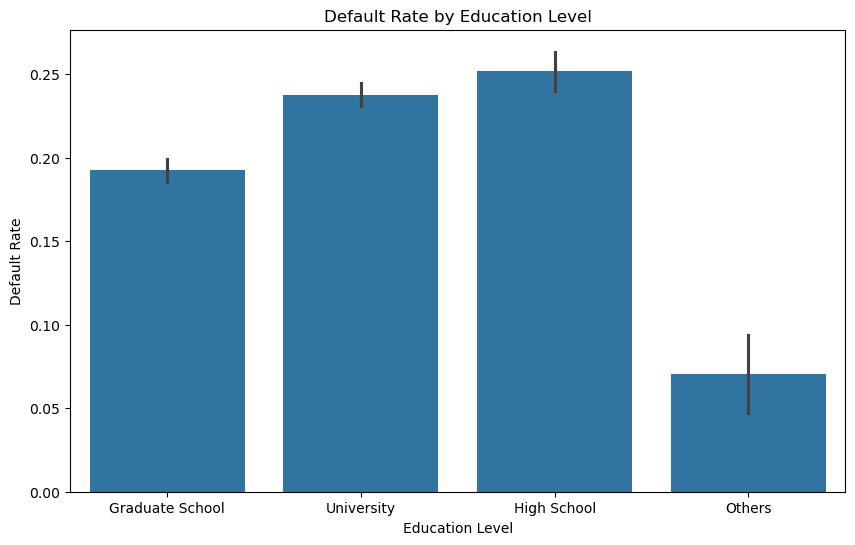

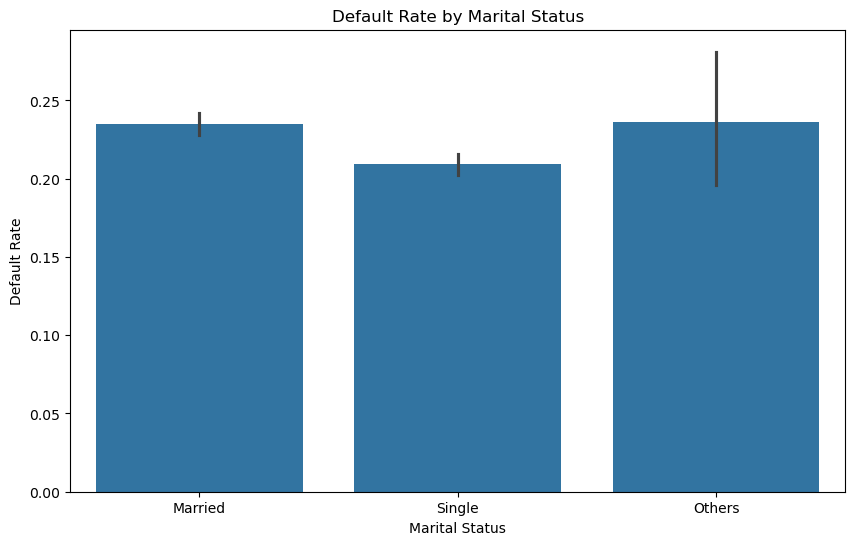

In [6]:
# Exploratory analysis of Education level and marital status columns
# Combine features and target for analysis
features['TARGET'] = target

# Analyze education level
plt.figure(figsize=(10, 6))
sns.barplot(
    x='EDUCATION_LEVEL', 
    y='TARGET', 
    data=features, 
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Default Rate by Education Level")
plt.ylabel("Default Rate")
plt.xlabel("Education Level")
plt.xticks(ticks=[0, 1, 2, 3], labels=['Graduate School', 'University', 'High School', 'Others'])
plt.show()

# Analyze marital status
plt.figure(figsize=(10, 6))
sns.barplot(
    x='MARITAL_STATUS', 
    y='TARGET', 
    data=features, 
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Default Rate by Marital Status")
plt.ylabel("Default Rate")
plt.xlabel("Marital Status")
plt.xticks(ticks=[0, 1, 2], labels=['Married', 'Single', 'Others'])
plt.show()

# Remove target column after analysis
features.drop(columns=['TARGET'], inplace=True)

Based off of the above barplots, we should treat education level and marital status as categorical varibales and not ordinal. This is because the difference between categories doesn’t seem to follow a strict ordinal relationship.

In [7]:
# Identify categorical and numerical columns
categorical_cols = ['GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS']
numerical_cols = [col for col in features.columns if col not in categorical_cols]

# Create preprocessing pipelines
# streamlines the process of applying a sequence of data transformations
# Imputer fills missing numerical values with the median value of the column.
# Scaler standardizes numerical values by subtracting the mean and dividing by the standard deviation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply preprocessing to features
processed_features = preprocessor.fit_transform(features)

# Confirm the preprocessing results
print("Processed features shape:", processed_features.shape)

Processed features shape: (30000, 29)


In [8]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    processed_features, target["DEFAULT"], test_size=0.2, random_state=42, stratify=target
)

# Confirm the split
print("Training features shape:", x_train.shape)
print("Testing features shape:", x_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (24000, 29)
Testing features shape: (6000, 29)
Training target shape: (24000,)
Testing target shape: (6000,)


In [9]:
# Show class distribution before SMOTE
unique_classes, counts_before = np.unique(y_train, return_counts=True)
print("Class distribution before SMOTE:", dict(zip(unique_classes, counts_before)))

# Apply SMOTE on the training data
smote = SMOTE(
    random_state=42,
    # Set minority class to 60% of the majority class
    sampling_strategy=1,
    k_neighbors=2
)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# Class distribution after SMOTE
unique, counts = np.unique(y_train_balanced, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique, counts)))

# Split the SMOTE-balanced data into training and validation sets
x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(
    x_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

Class distribution before SMOTE: {0: 18691, 1: 5309}
Class distribution after SMOTE: {0: 18691, 1: 18691}


In [10]:
# Automatically calculate weights
unique_classes = np.unique(y_train_smote)  # Ensure balanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_smote
)

# Convert to dictionary
class_weight_dict = {unique_classes[i]: class_weights[i] for i in range(len(unique_classes))}

In [11]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=5,         # Allow trees to grow fully
    class_weight=class_weight_dict,
    random_state=42
)

# Train the Random Forest on the SMOTE-balanced data
rf_model.fit(x_train_smote, y_train_smote)

# Predict on the original test set
y_pred_rf = rf_model.predict(x_test)

# Evaluate the Random Forest
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.50      0.57      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.70      6000
weighted avg       0.79      0.78      0.79      6000

Random Forest Confusion Matrix:
 [[3930  743]
 [ 573  754]]


In [12]:
# Function to create ANN model
def create_ann():
    ann = Sequential([
        # Define the input shape explicitly. 
        Input(shape=(x_train.shape[1],)),

        # First hidden layer with 64 units and reLU activation function.
        Dense(units=64, activation='relu'),
        
        # Add dropout for regularization
        Dropout(.3),
        
        # Second hidden layer with 32 units and reLU activation function.
        Dense(units=32, activation='relu'),

        # Output layer with 1 unit and the Sigmoid activation function for binary classification
        Dense(units=1, activation='sigmoid')
    ])
    ann.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return ann

# EarlyStopping callback will stop running epochs if the val_loss doesnt have significant changes after 5 iterations.
early_stopping = EarlyStopping(
    # Watch validation loss
    monitor='val_loss',
    # Stop if no improvement after 5 consecutive epochs
    patience=5,
    # Restore the best weights during training
    restore_best_weights=True
)

# Wrap the ANN model using KerasClassifier
ann_model = KerasClassifier(
    model=create_ann,
    # Number of training iterations. 7-15 seem to be where it tends to stop early based off of the early_stopping callback.
    epochs=50,
    
    # Number of samples per gradient update
    batch_size=32,
    
    # Print progress during training
    verbose=1,

    # early stopping callback
    callbacks=[early_stopping],

    # add 20% validation split 
    validation_split=0.2,

    # Add class weights
    class_weight=class_weight_dict
)

In [13]:
# Create a pipeline for Logistic Regression with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        class_weight=class_weight_dict,
        random_state=42,
        
        # Increased max_iter for convergence
        max_iter=1000,
        
        # default solver
        solver='lbfgs'
    ))
])

In [14]:
# Create the Voting Classifier integrating the Logistic Regression pipeline
voting_clf = VotingClassifier(
    estimators=[
        # ANN (Wrapped with KerasClassifier)
        ('ann', ann_model),
        
        # Random Forest
        ('rf', rf_model),
        
        # Logistic Regression Pipeline
        ('lr', lr_pipeline)
    ],
    # Use probability-based voting
    voting='soft',
    
    # Give more weight to models with better default recall
    weights=[1, 2, 3]
)

# Train the voting classifier
voting_clf.fit(x_train_smote, y_train_smote)

Epoch 1/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6743 - loss: 0.6055 - val_accuracy: 0.7009 - val_loss: 0.5684
Epoch 2/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6978 - loss: 0.5774 - val_accuracy: 0.7032 - val_loss: 0.5614
Epoch 3/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7055 - loss: 0.5667 - val_accuracy: 0.7121 - val_loss: 0.5653
Epoch 4/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7039 - loss: 0.5690 - val_accuracy: 0.7029 - val_loss: 0.5591
Epoch 5/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7065 - loss: 0.5635 - val_accuracy: 0.7123 - val_loss: 0.5555
Epoch 6/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7080 - loss: 0.5580 - val_accuracy: 0.7131 - val_loss: 0.5507
Epoch 7/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7102 - loss: 0.5560 - val_accuracy: 0.7134 - val_loss: 0.5481
Epoch 8/50
748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.7110 - loss: 0.5590 - val_accuracy: 

VotingClassifier(estimators=[('ann',
                              KerasClassifier(batch_size=32, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x17cb734c0>], class_weight={0: 1.0026486957687923, 1: 0.9973652614727855}, epochs=50, model=<function create_ann at 0x17cb5f1c0>, validation_split=0.2)),
                             ('rf',
                              RandomForestClassifier(class_weight={0: 1.0026486957687923,
                                                                   1: 0.9973652614727855},
                                                     max_depth=5,
                                                     random_state=42)),
                             ('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('logreg',
                                               LogisticRegression(class_weight={0: 1.0026486957687923,
                                                                                1: 0.9973652614727855},
                                                                  max_iter=1000,
                                                                  random_state=42))]))],
                 voting='soft', weights=[1, 2, 3])

In [15]:
# Predict on the test set using the VotingClassifier
y_pred_voting = voting_clf.predict(x_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_voting))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
Test Accuracy: 0.7435

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      4673
           1       0.44      0.61      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000


Confusion Matrix:
 [[3651 1022]
 [ 517  810]]
